# Tensor operations

Please implement the below function `min_dist`. This function should take a sparse list of 2D coordinates, and map them to a 2D tensor of a specified resolution. The values of each pixel in the tensor should correspond to the [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between that pixel and the closest pixel which contains a data point.

You can use either numpy or pytorch tensor operations to implement the function. Use only tensor operations, no for-loops are necessary.

Here are the example outputs for the two test cases highlighted below:

Case 1: data at `[0.4, 0.3], [0.6, 0.7]`, resolution 20 pixels.

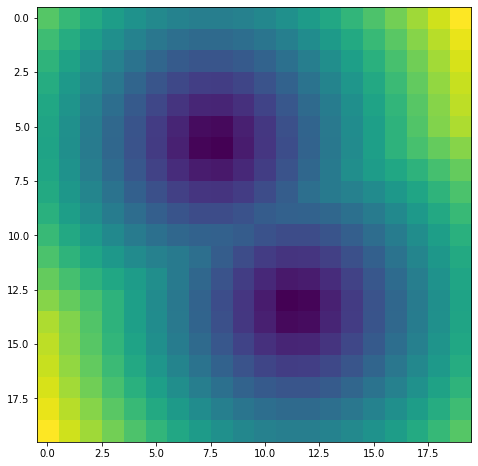


Case 2: data at `[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]`, resolution 256 pixels.

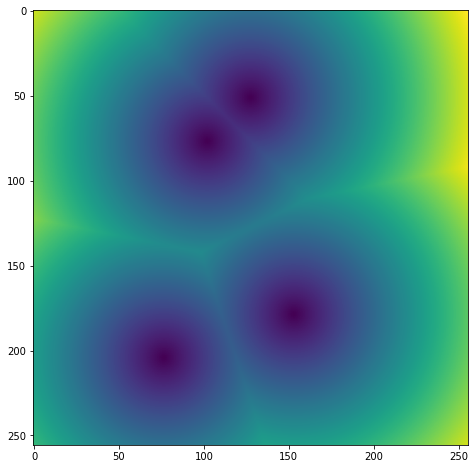


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


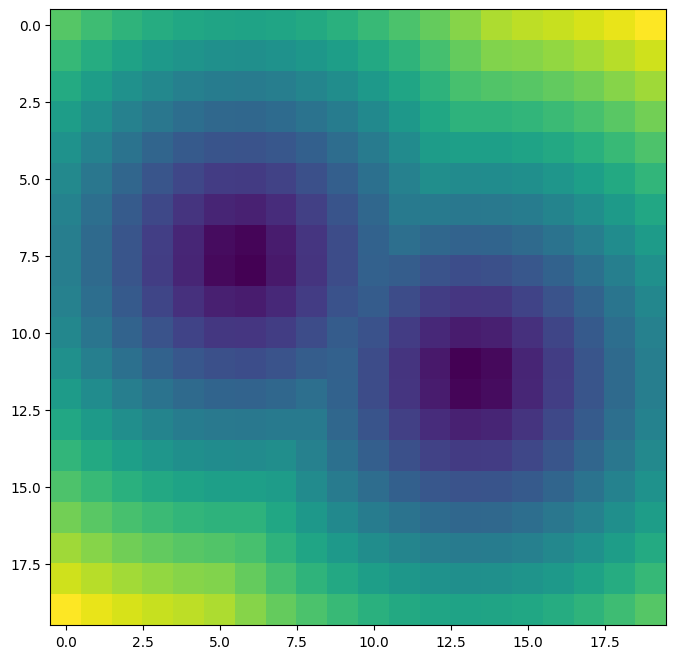

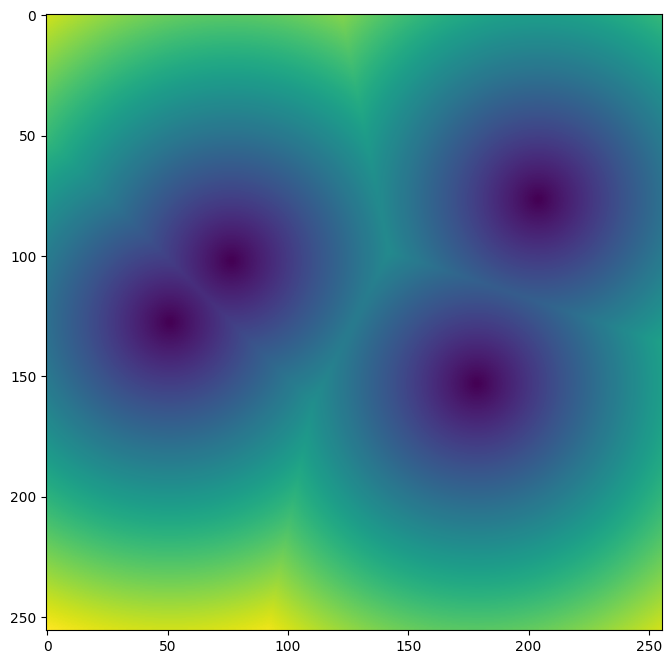

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def min_dist(points, res):
    """Calculates a 2D tensor with the minimum distance from each pixel to data.

    Inputs:
      * points: a python list of 2D coordinates, normalized in the range [0,1]
      * res: the resolution of the output tensor.
    Returns:
      A res x res square tensor with floating point values corresponding to the
      euclidean distance to the closest point in points.
    """
    spacing = torch.linspace(0, 1, res)
    grid_x, grid_y = torch.meshgrid(spacing, spacing)

    grid = torch.stack([grid_x, grid_y], dim=-1)

    points = torch.tensor(points)

    pt_vec = grid.view(-1, 2)
    distances = torch.cdist(pt_vec, points, p=2)  # p=2 is euclidean

    min_distances = distances.min(dim=1).values

    min_distances = min_distances.view(res, res)

    return min_distances


distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7]], 20)
plt.figure(figsize=(8, 8))
plt.imshow(distance_to_data)

distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]], 256)
plt.figure(figsize=(8, 8))
plt.imshow(distance_to_data)

# Batched version

As a next step, improve the `min_dist` function to support batches.
The `points` array is now expected to be a tensor with shape [batch_size, num_points, 3], generated by `create_points`.
`min_dist` should return a batch of maps with shape [batch_size, res, res].
Again, make sure to implement `min_dist` using **no for-loops**.
Demonstrate your function output with `batch_size=3` and `num_points=4`.

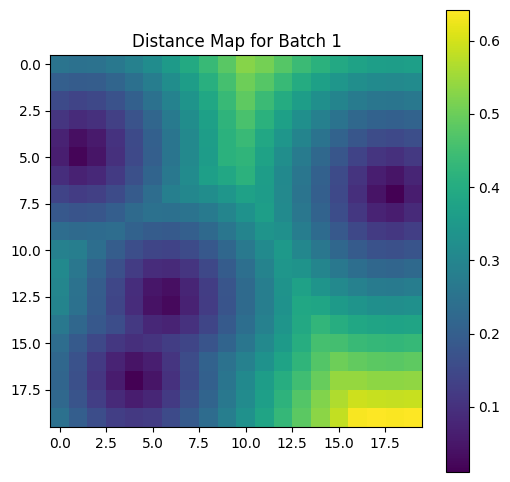

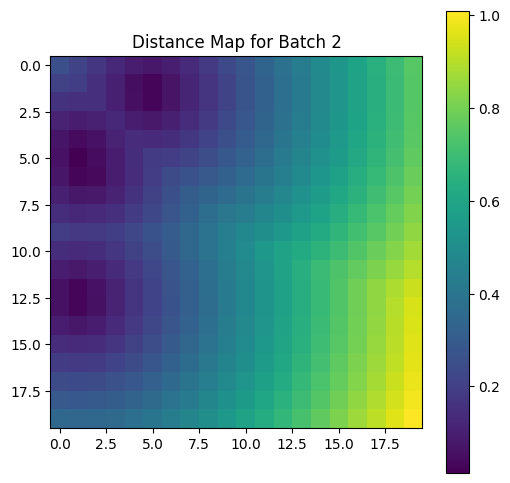

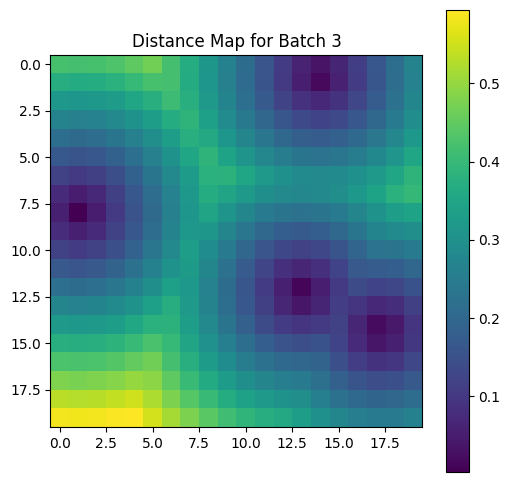

In [ ]:

import numpy as np
import torch
import matplotlib.pyplot as plt

def min_dist(points, res):
    """
    Calculates a 3D tensor with the minimum distance from each pixel to data.

    Inputs:
      * points: a tensor of 2D coordinates with shape [batch_size, num_points, 2],
                normalized in the range [0, 1].
      * res: the resolution of the output tensor.
    Returns:
      A tensor of shape [batch_size, res, res] with floating point values corresponding to the
      Euclidean distance to the closest point in points.
    """

    batch_size = points.shape[0]

    spacing = torch.linspace(0, 1, res)
    grid_x, grid_y = torch.meshgrid(spacing, spacing)

    grid = torch.stack([grid_x, grid_y], dim=-1)

    pt_vec = grid.view(-1, 2).unsqueeze(0).expand(batch_size, -1, -1) # batch support: unsqueeze + expand
    distances = torch.cdist(pt_vec, points, p=2)  # p=2 is euclidean

    min_distances = distances.min(dim=2).values # batch support: dim=2

    min_distances = min_distances.view(batch_size, res, res) # batch support: batch size

    return min_distances


def create_points(batch_size, num_points):
    """Generates random 2D points in the range [0,1] for each batch."""
    return torch.rand(batch_size, num_points, 2)

batch_size = 3
num_points = 4
res = 20

points = create_points(batch_size, num_points)

distance_maps = min_dist(points, res)


for i in range(batch_size):
    plt.figure(figsize=(6, 6))
    plt.title(f"Distance Map for Batch {i+1}")
    plt.imshow(distance_maps[i].numpy(), cmap='viridis')
    plt.colorbar()
    plt.show()


# Scalable version

Assume `res` can be very large (up to 65,536). Running the above function will likely cause the computer's RAM to be filled up, and fail (on a free colab instance, even 16,384 `res` will crash with `batch_size=3` and `num_points=4`).
Extend the above version of `min_dist` to calculate the result tensor at such high resolution without running out of RAM. This function may be less computationally efficient, as long as it can successfully run.

# Solution remarks

I figured out that I could save result of chunk computation into files on disk.


All chunks have been saved to disk.


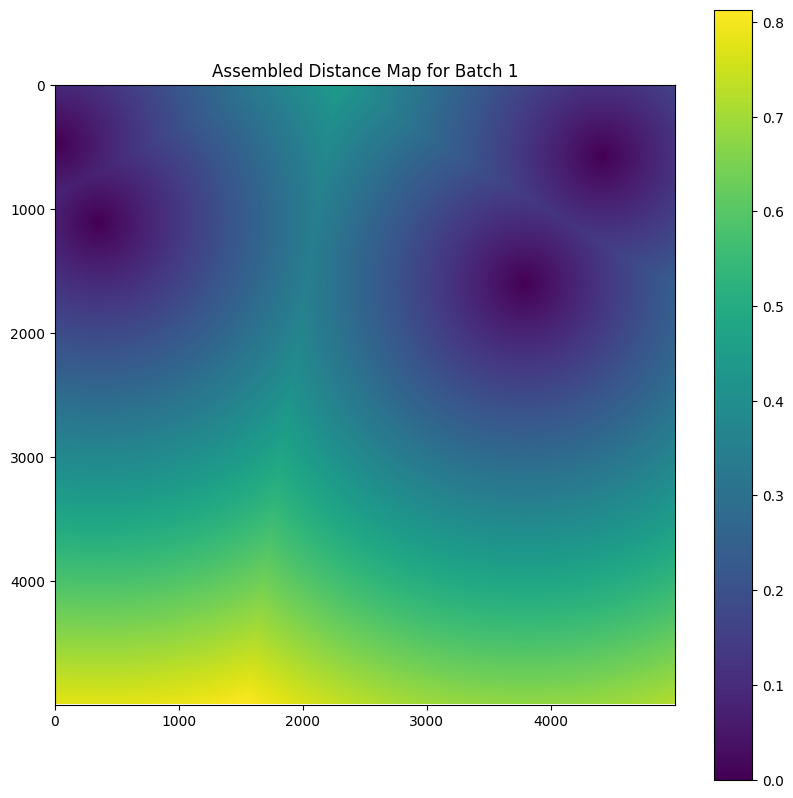

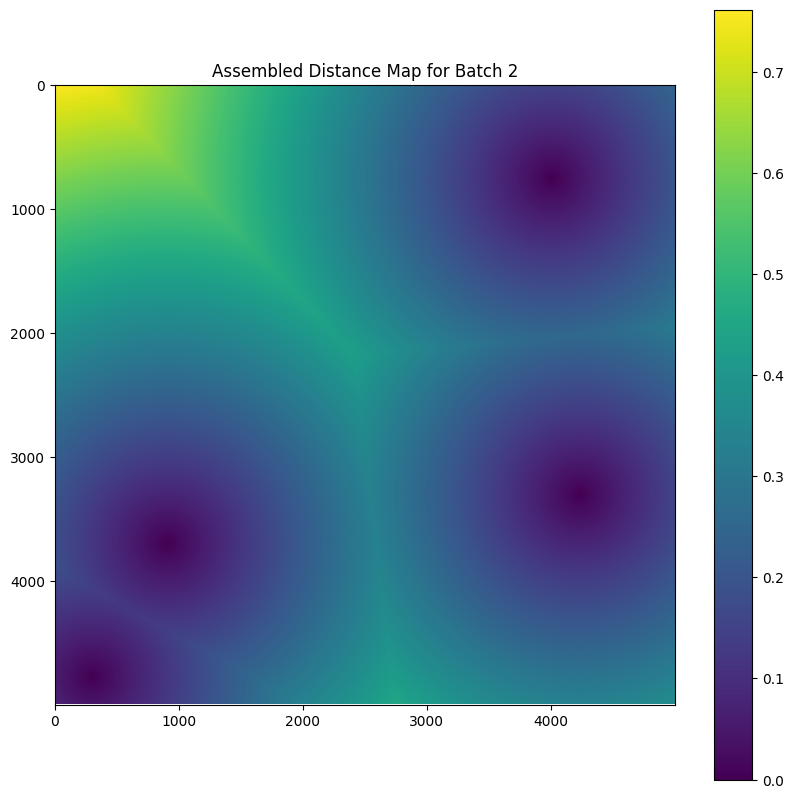

In [ ]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

def min_dist(points, res, chunk_size=1024, output_dir="output_chunks"):
    """
    Calculates a 3D tensor with the minimum distance from each pixel to data using a chunk-based and file-backed approach.

    Inputs:
      * points: a tensor of 2D coordinates with shape [batch_size, num_points, 2],
                normalized in the range [0, 1].
      * res: the resolution of the output tensor.
      * chunk_size: the size of chunks for which to calculate distances along each axis.
      * output_dir: the directory to store intermediate chunk results.
    """
    batch_size = points.shape[0]

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    spacing = torch.linspace(0, 1, res)

    for i in range(0, res, chunk_size):
        i_end = min(i + chunk_size, res)
        chunk_spacing_x = torch.linspace(i / res, i_end / res, i_end - i)

        for j in range(0, res, chunk_size):
            j_end = min(j + chunk_size, res)
            chunk_spacing_y = torch.linspace(j / res, j_end / res, j_end - j)

            grid_x, grid_y = torch.meshgrid(chunk_spacing_x, chunk_spacing_y, indexing='ij')

            grid_chunk = torch.stack([grid_x, grid_y], dim=-1).view(-1, 2)

            grid_chunk_expanded = grid_chunk.unsqueeze(0).expand(batch_size, -1, -1)

            distances = torch.cdist(grid_chunk_expanded, points, p=2)

            min_chunk_distances = distances.min(dim=2).values

            min_chunk_distances_reshaped = min_chunk_distances.view(batch_size, i_end - i, j_end - j)

            for b in range(batch_size):
                file_name = os.path.join(output_dir, f"batch_{b}_chunk_{i}_{j}.npy")
                np.save(file_name, min_chunk_distances_reshaped[b].cpu().numpy())

    print("All chunks have been saved to disk.")

def create_points(batch_size, num_points):
    """Generates random 2D points in the range [0,1] for each batch."""
    return torch.rand(batch_size, num_points, 2)

batch_size = 2
num_points = 4
res = 5000
chunk_size = 1000

points = create_points(batch_size, num_points)

min_dist(points, res, chunk_size)

output_dir = "output_chunks"

min_distances = torch.full((batch_size, res, res), float('inf'))

for i in range(0, res, chunk_size):
    i_end = min(i + chunk_size, res)

    for j in range(0, res, chunk_size):
        j_end = min(j + chunk_size, res)

        for b in range(batch_size):
            file_name = os.path.join(output_dir, f"batch_{b}_chunk_{i}_{j}.npy")
            if os.path.exists(file_name):
                chunk_data = np.load(file_name)

                min_distances[b, i:i_end, j:j_end] = torch.tensor(chunk_data)
            else:
                print(f"Chunk file {file_name} does not exist.")

for i in range(batch_size):
    plt.figure(figsize=(10, 10))
    plt.title(f"Assembled Distance Map for Batch {i+1}")
    plt.imshow(min_distances[i].numpy(), cmap='viridis')
    plt.colorbar()
    plt.show()
